In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [25]:
df = pd.read_csv('monthly_csv.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df.set_index('Date', inplace=True)
df = df[df.index >= '1971-01-01']
df.head()

,Price
Date,
1971-01-01,37.868
1971-02-01,38.716
1971-03-01,38.873
1971-04-01,39.001
1971-05-01,40.493


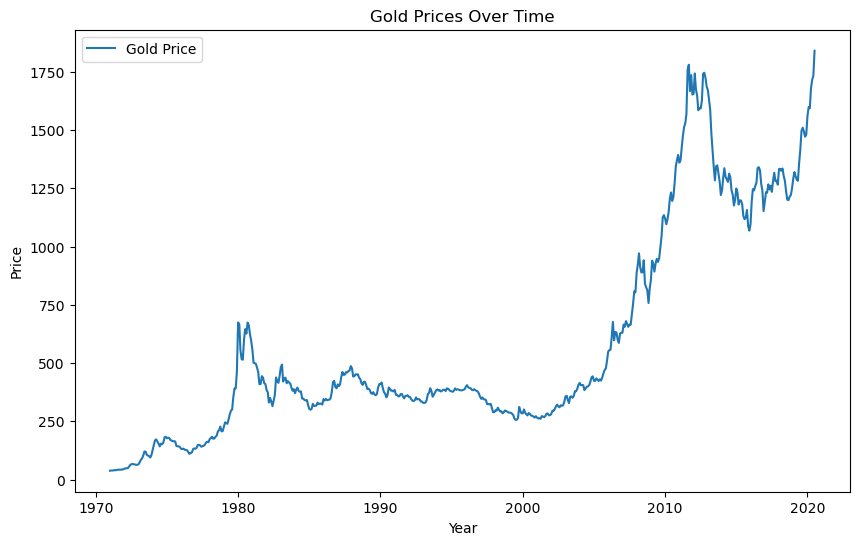

In [26]:
# Plot der ursprünglichen Zeitreihe
plt.figure(figsize=(10, 6))
plt.plot(df['Price'], label='Gold Price')
plt.title('Gold Prices Over Time')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

In [27]:
# Augmented Dickey-Fuller-Test zur Überprüfung der Stationarität
result = adfuller(df['Price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values (1%):', result[4]["1%"])
print('Critical Values (5%):', result[4]["5%"])
print('Critical Values (10%):', result[4]["10%"])

ADF Statistic: 0.2368633123125436
p-value: 0.974254988465328
Critical Values (1%): -3.441616425652826
Critical Values (5%): -2.866510292004876
Critical Values (10%): -2.5694170294713863


**p-Value**, weit über 0,05, daher ist die Zeitreihe nicht-stationär und muss differenziert werden.

**ADF-Statistics:** kritische Werte sind kleiner als die ADF Statistic, daher kann die Nullhypothese abgelehnt werden.

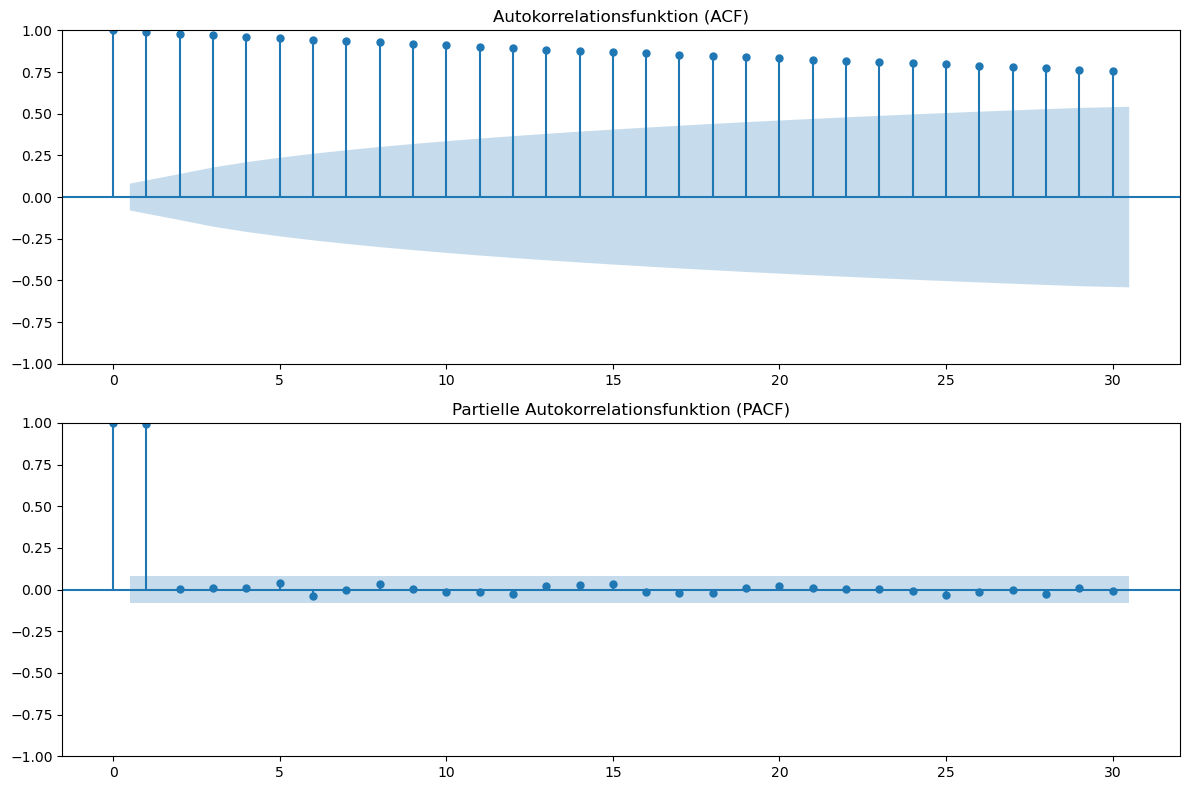

In [28]:
# 2. ACF und PACF Plots erstellen:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# ACF Plot
plot_acf(df['Price'], lags=30, ax=axes[0])
axes[0].set_title('Autokorrelationsfunktion (ACF)')

# PACF Plot
plot_pacf(df['Price'], lags=30, ax=axes[1])
axes[1].set_title('Partielle Autokorrelationsfunktion (PACF)')

plt.tight_layout()
plt.show()

Langsam abklingender Autokorrelationsplot deutet auf eine Nicht-Stationalität hin.
Der Signifikante Peak beim Lag 1 im PACF Plot deutet darauf hin, dass es zu empfehlen ist ein AR(1) Modell zu verwenden.
Ein ARIMA(1,1,0) Modell könnte geeignet sein. Dieses beinhaltet ein AR(1) mit einer Differenzierung und keine Moving Average Term hin. 
Ein MA(q)-Modell zeigt typischerweise im ACF Diagramm bis Lag q eine signifikante Autokorrelation und fällt dann bis uf 0 ab. Dies ist hier nicht der Fall.     


In [29]:
# 3. ARIMA(1,1,0)-Modell erstellen und schätzen
model = ARIMA(df['Price'], order=(1, 1, 0))
model_fit = model.fit()

# 4. Modellergebnisse anzeigen
print(model_fit.summary())



                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  595
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2844.800
Date:                Sun, 30 Jun 2024   AIC                           5693.599
Time:                        16:51:49   BIC                           5702.373
Sample:                    01-01-1971   HQIC                          5697.016
                         - 07-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2261      0.026      8.683      0.000       0.175       0.277
sigma2       847.3806     22.562     37.558      0.000     803.160     891.601
Ljung-Box (L1) (Q):                   0.11   Jarque-

/Users/m.dederichs/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/m.dederichs/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/m.dederichs/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [30]:
# 5. Prognosen erstellen
forecast = model_fit.forecast(steps=30)
print(forecast)

2020-08-01    1864.949169
2020-09-01    1870.407791
2020-10-01    1871.642003
2020-11-01    1871.921062
2020-12-01    1871.984158
2021-01-01    1871.998425
2021-02-01    1872.001650
2021-03-01    1872.002379
2021-04-01    1872.002544
2021-05-01    1872.002582
2021-06-01    1872.002590
2021-07-01    1872.002592
2021-08-01    1872.002592
2021-09-01    1872.002593
2021-10-01    1872.002593
2021-11-01    1872.002593
2021-12-01    1872.002593
2022-01-01    1872.002593
2022-02-01    1872.002593
2022-03-01    1872.002593
2022-04-01    1872.002593
2022-05-01    1872.002593
2022-06-01    1872.002593
2022-07-01    1872.002593
2022-08-01    1872.002593
2022-09-01    1872.002593
2022-10-01    1872.002593
2022-11-01    1872.002593
2022-12-01    1872.002593
2023-01-01    1872.002593
Freq: MS, Name: predicted_mean, dtype: float64


Modell ist nicht ausreichend Komplex, um den Goldpreis effektiv vorherzusagen. Es fehlen außerdem weitere Faktoren wie geopolitische Ereignisse oder andere Rohstoffpreise.

Im nachfolgenden wird eine MA Komponente noch mit beachtet. Um Kurzfristige Schwankungen mit zu beachten:

In [31]:
# 3. ARIMA(1,1,1)-Modell erstellen und schätzen
model = ARIMA(df['Price'], order=(1, 1, 1))
model_fit = model.fit()

# 4. Modellergebnisse anzeigen
print(model_fit.summary())





/Users/m.dederichs/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/m.dederichs/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/m.dederichs/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  595
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2839.540
Date:                Sun, 30 Jun 2024   AIC                           5685.080
Time:                        16:51:49   BIC                           5698.240
Sample:                    01-01-1971   HQIC                          5690.205
                         - 07-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5391      0.060     -8.973      0.000      -0.657      -0.421
ma.L1          0.7656      0.045     17.066      0.000       0.678       0.854
sigma2       830.9116     22.372     37.141      0.0

In [32]:
# 5. Prognosen erstellen
forecast = model_fit.forecast(steps=20)
print(forecast)

2020-08-01    1857.355217
2020-09-01    1848.433537
2020-10-01    1853.243504
2020-11-01    1850.650295
2020-12-01    1852.048378
2021-01-01    1851.294626
2021-02-01    1851.700998
2021-03-01    1851.481910
2021-04-01    1851.600027
2021-05-01    1851.536346
2021-06-01    1851.570679
2021-07-01    1851.552169
2021-08-01    1851.562148
2021-09-01    1851.556768
2021-10-01    1851.559669
2021-11-01    1851.558105
2021-12-01    1851.558948
2022-01-01    1851.558493
2022-02-01    1851.558739
2022-03-01    1851.558606
Freq: MS, Name: predicted_mean, dtype: float64


Ähnliches Problem wie bei ohne MA.

Berücksichtigung möglicher Saisionaler Trends. Annahme das je nach Monat die Preise anders sein könnten.

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA-Modell erstellen und schätzen
model_sarima = SARIMAX(df['Price'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_sarima_fit = model_sarima.fit()

# Modellergebnisse anzeigen
print(model_sarima_fit.summary())



/Users/m.dederichs/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/m.dederichs/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.82651D+00    |proj g|=  7.46159D-02

At iterate    5    f=  4.78734D+00    |proj g|=  1.34142D-02

At iterate   10    f=  4.71521D+00    |proj g|=  2.84236D-02

At iterate   15    f=  4.70929D+00    |proj g|=  1.33304D-02

At iterate   20    f=  4.70830D+00    |proj g|=  2.68274D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     27      1     0     0   2.683D-06   4.708D+00
  F =   4.7082991361785895     

CONVERG

In [34]:
# Prognosen erstellen
forecast_sarima = model_sarima_fit.forecast(steps=24)
print(forecast_sarima)

2020-08-01    1864.703463
2020-09-01    1866.008089
2020-10-01    1870.911119
2020-11-01    1866.015587
2020-12-01    1867.620832
2021-01-01    1881.904647
2021-02-01    1891.145825
2021-03-01    1886.595087
2021-04-01    1889.766738
2021-05-01    1891.090257
2021-06-01    1892.524510
2021-07-01    1899.240948
2021-08-01    1907.076947
2021-09-01    1916.213379
2021-10-01    1917.019080
2021-11-01    1915.438334
2021-12-01    1915.250120
2022-01-01    1928.344766
2022-02-01    1936.137507
2022-03-01    1931.909545
2022-04-01    1932.265626
2022-05-01    1932.601335
2022-06-01    1933.439698
2022-07-01    1937.013648
Freq: MS, Name: predicted_mean, dtype: float64


Hier werden nun mit einer Bewley-Transformation genutzt um langfristige Beziehungen zwischen den Variabeln besser zu verstehen.  

In [35]:
# Langfristigen Multiplikator berechnen
phi = model_fit.arparams[0]  # AR(1) Koeffizient
theta = model_fit.maparams[0]  # MA(1) Koeffizient

# Langfristiger Multiplikator
long_term_multiplier = phi / (1 - theta)

print("Langfristiger Multiplikator:", long_term_multiplier)

# Prognosen erstellen
forecast = model_fit.forecast(steps=24)
print(forecast)

Langfristiger Multiplikator: -2.3000955910689305
2020-08-01    1857.355217
2020-09-01    1848.433537
2020-10-01    1853.243504
2020-11-01    1850.650295
2020-12-01    1852.048378
2021-01-01    1851.294626
2021-02-01    1851.700998
2021-03-01    1851.481910
2021-04-01    1851.600027
2021-05-01    1851.536346
2021-06-01    1851.570679
2021-07-01    1851.552169
2021-08-01    1851.562148
2021-09-01    1851.556768
2021-10-01    1851.559669
2021-11-01    1851.558105
2021-12-01    1851.558948
2022-01-01    1851.558493
2022-02-01    1851.558739
2022-03-01    1851.558606
2022-04-01    1851.558678
2022-05-01    1851.558639
2022-06-01    1851.558660
2022-07-01    1851.558649
Freq: MS, Name: predicted_mean, dtype: float64


-  Negatives Vorzeichen zeigt, dass ein positiver Schock in der erklärenden Variable kurzfristig zu einem Anstieg des Goldpreises führt.

- Langfristig führt dieser Effekt jedoch zu einem Rückgang des Goldpreises, durch evtl. Marktanpassungen wie Gewinnmitnahmen oder wirtschaftliche Erholung.